In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

#astro
from astropy.cosmology import WMAP9 as cosmo
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1)
import seaborn as sns

#optional 3ML imports


from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')


import pystan

In [11]:
def dNdz(z,r0,a, b):
    
    return r0 * np.power(z+1,a) * np.exp(-z/b)
    
    

In [12]:
def draw_zs(r0, alpha, beta):
    zs = np.linspace(0, 10, 1000)
    dndzs = dNdz(zs, r0, alpha, beta)
    ymax = np.max(dndzs)
    Nex = integrate.quad(dNdz,0.,10.,args=(r0,alpha, beta))[0]
    Ndraw = np.random.poisson(Nex)
    igen = 0
    while igen < Ndraw:
        y = np.random.uniform(low=0, high=ymax)
        z = np.random.uniform(low=0, high=10)
        if y < dNdz(z, r0, alpha, beta):
            igen += 1
            yield z

In [29]:
zsample = np.array([z for z in draw_zs(20., 2.,2.)])

noise_level = .1

#noise = np.random.normal(scale = 0.2, size=len(zsample))

z_measured = np.exp(np.log(zsample) + noise_level* np.random.normal(size=len(zsample)))




In [32]:
z_threshold = 6
selection = z_measured < z_threshold

<IPython.core.display.Javascript object>


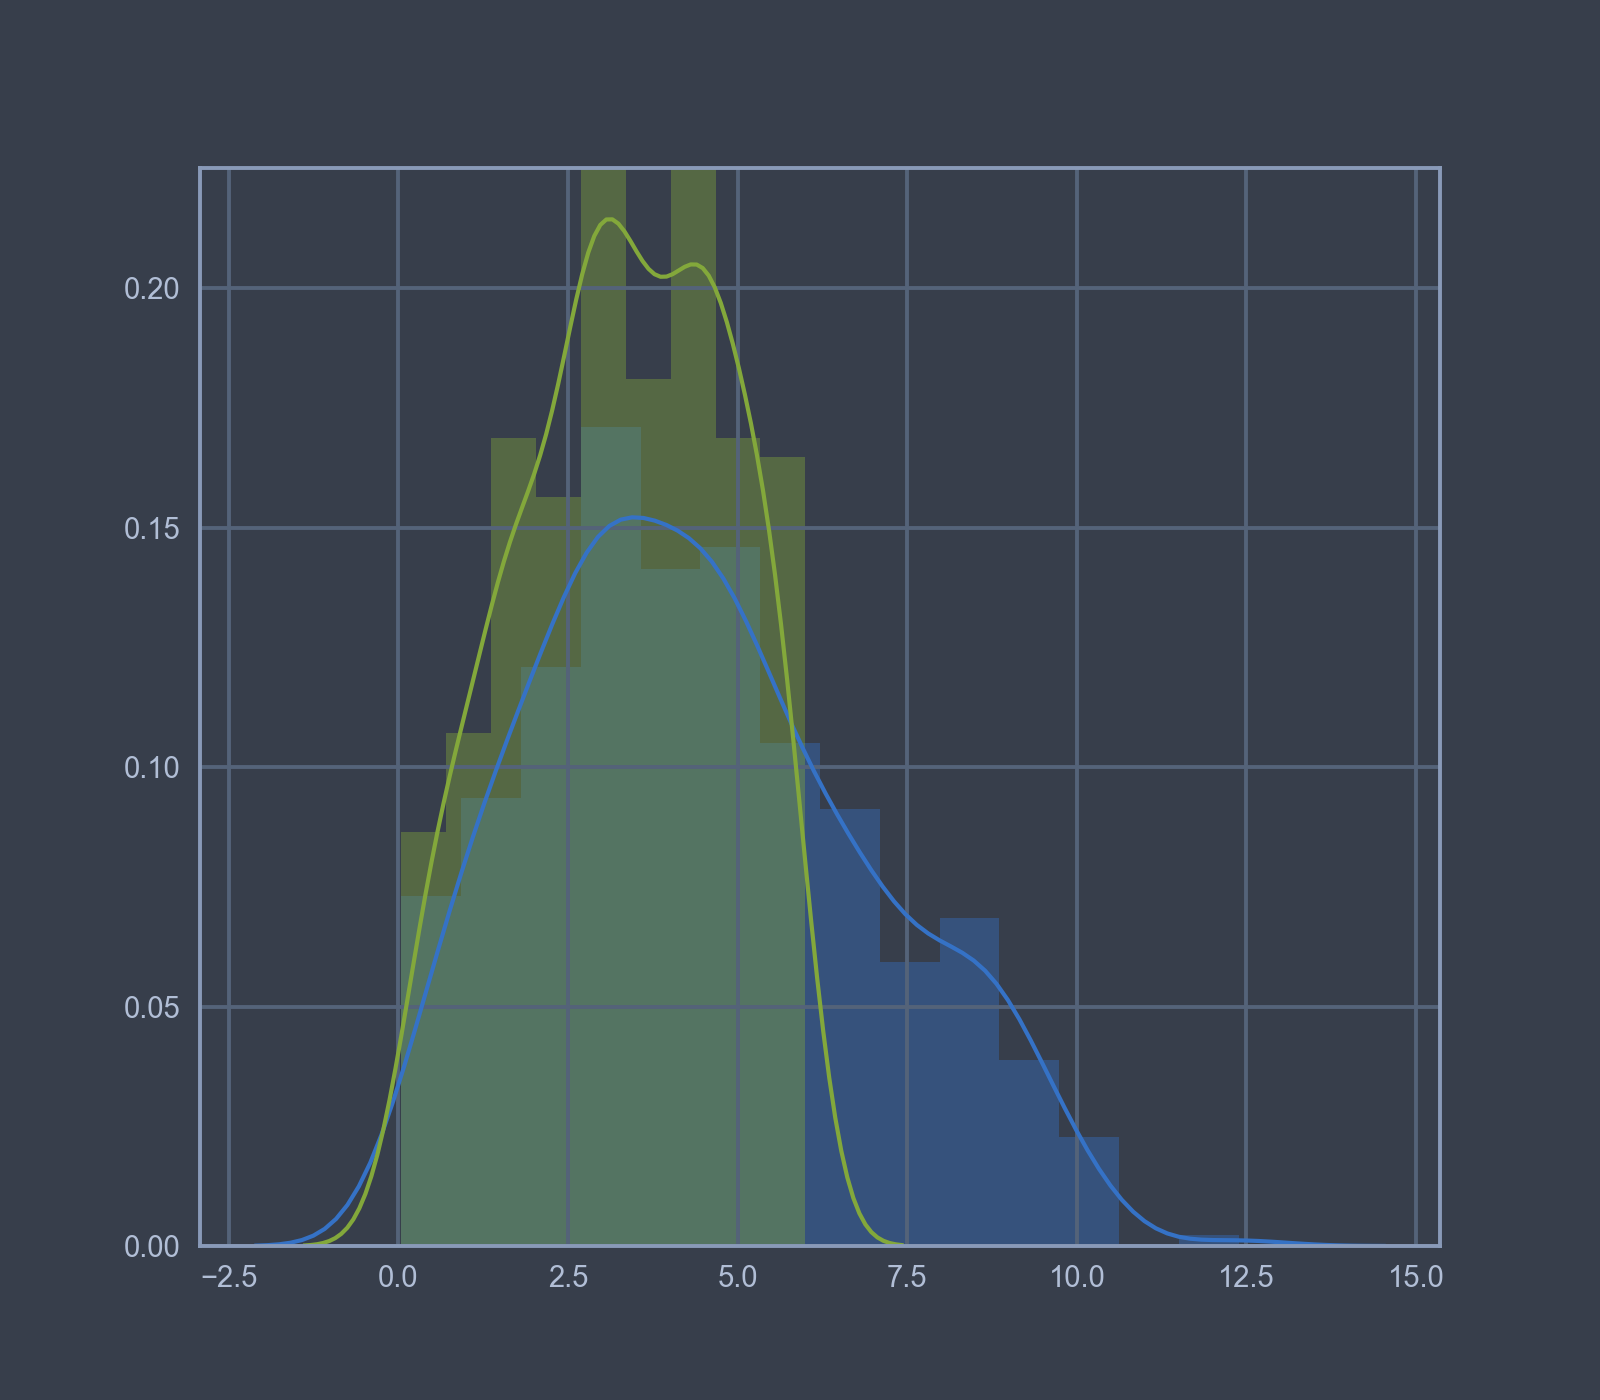

497 367


/Users/jburgess/.environs/science3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [33]:
fig, ax = plt.subplots()

sns.distplot(z_measured)
sns.distplot(z_measured[selection])

print(len(z_measured), len(z_measured[selection]))

In [34]:
model = pystan.StanModel(file='marginal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7122d3e367d4fa08d7716ad2914a4f96 NOW.


In [35]:
zmodel = np.linspace(0,10,500)


In [36]:
fit = model.sampling(
    data = {'nobs': len(z_measured[selection]), 
            'zobs': z_measured[selection],
            'Nnobs_max': 500,
            'sigma_obs': noise_level,
            'zth': z_threshold,
        'zs_model': zmodel,
        'nmodel':500},
    iter = 4000,
    thin = 2)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


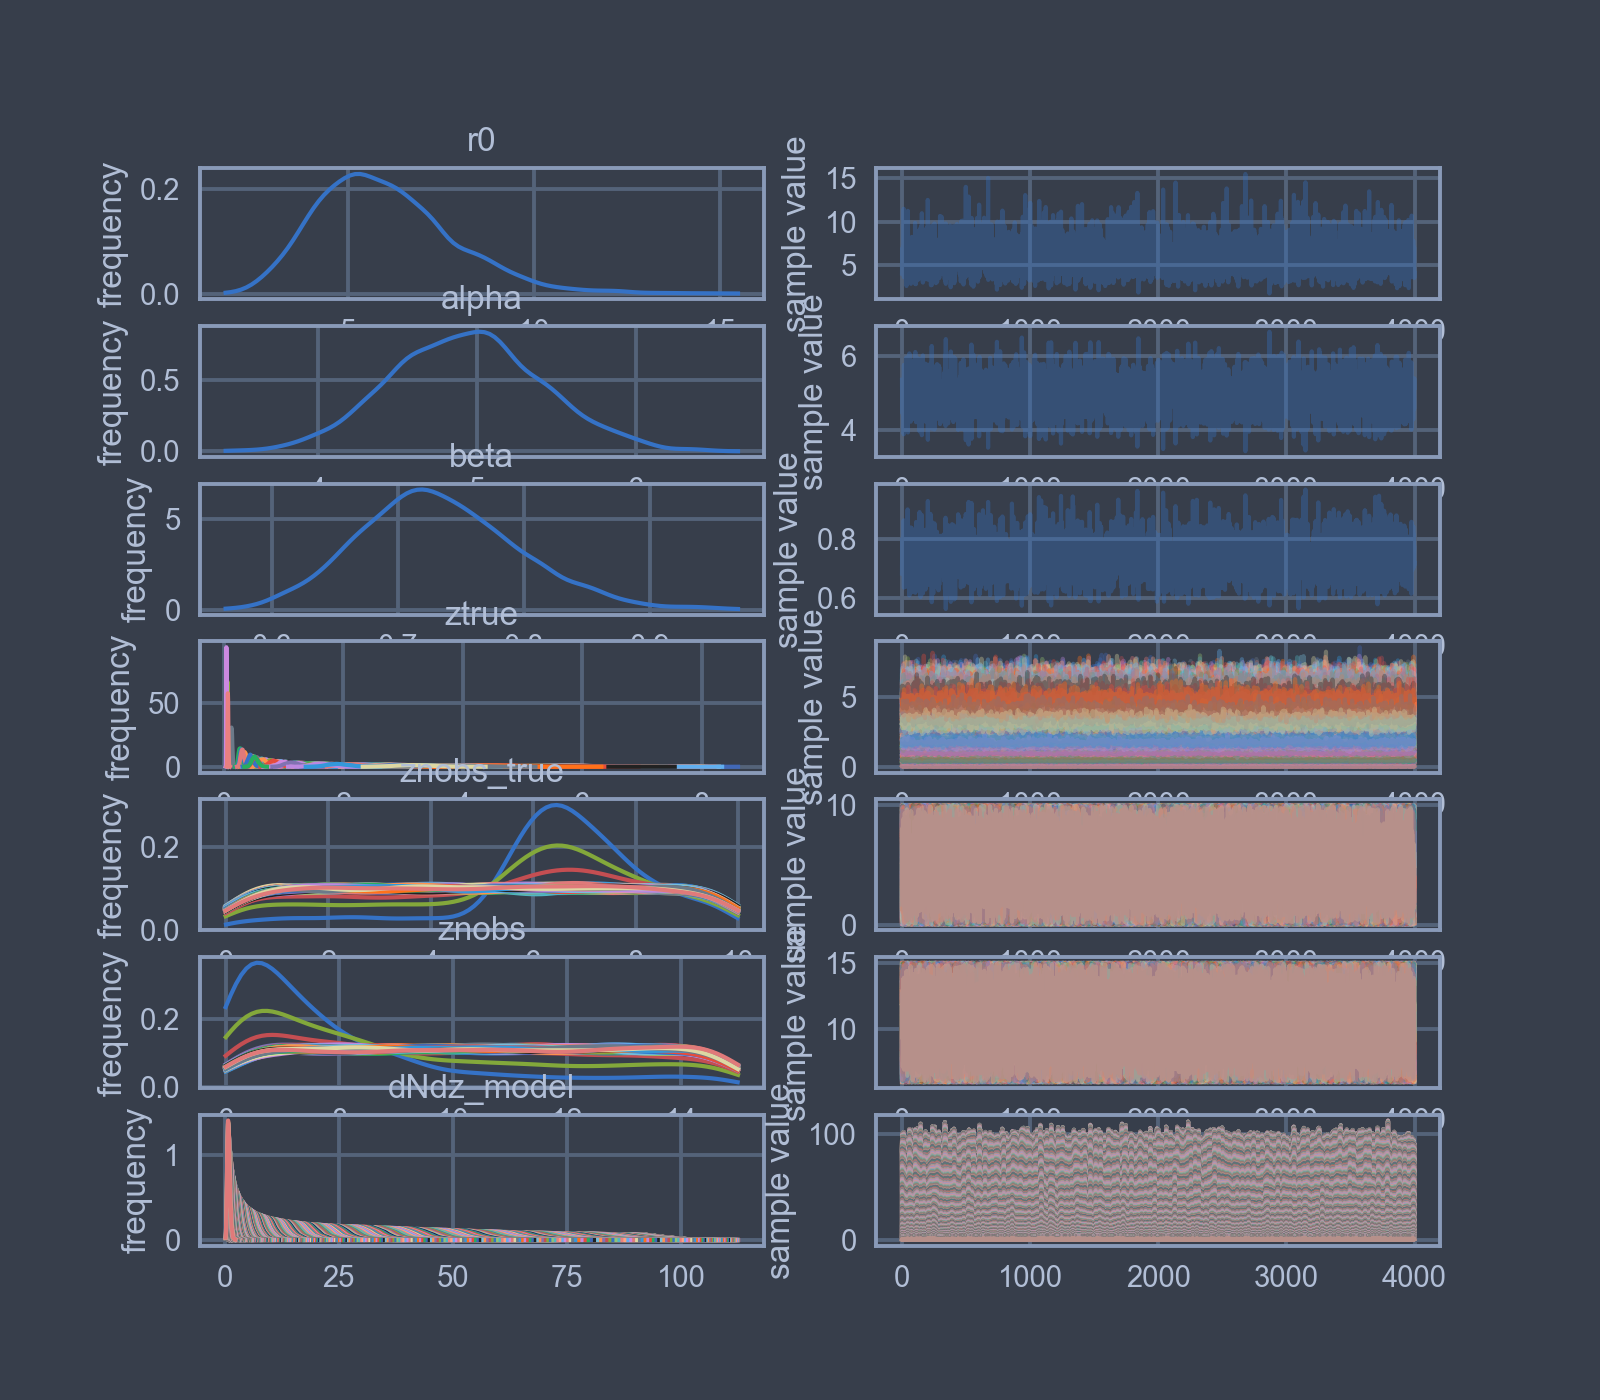

In [37]:
fit.plot();

In [21]:
fit

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jburgess/.environs/science3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/jburgess/.environs/science3/lib/python3.6/site-packages/numpy/core/_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


Inference for Stan model: anon_model_8c3f52161e673cd48e33f3556fc9940f.
4 chains, each with iter=4000; warmup=2000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r0              125.67    4.97   7.03  115.6 119.94  123.7 133.39 137.78      2   5.33
alpha             1.47    0.03   0.05   1.38   1.43   1.48   1.51   1.53      2   5.93
ztrue[0]          1.19    0.03   0.05   1.13   1.14   1.17   1.22   1.32      3   2.06
ztrue[1]           1.3     0.1   0.15   1.04   1.14   1.35   1.42   1.47      2   9.18
ztrue[2]          6.52    0.34   0.49   5.65   6.11   6.66    6.9   7.05      2  21.53
ztrue[3]          1.56    0.08   0.11   1.43   1.46   1.52   1.64   1.76      2   9.13
ztrue[4]          1.51     0.1   0.14   1.34   1.35   1.51   1.63   1.76      2  10.54
ztrue[5]          0.26    0.01   0.02   0.23   0.25   0.26   0.27   0.28      2   4.95
ztrue[6]          2.91    0.

In [24]:
chain_selected = fit.extract(permuted=True)


<IPython.core.display.Javascript object>


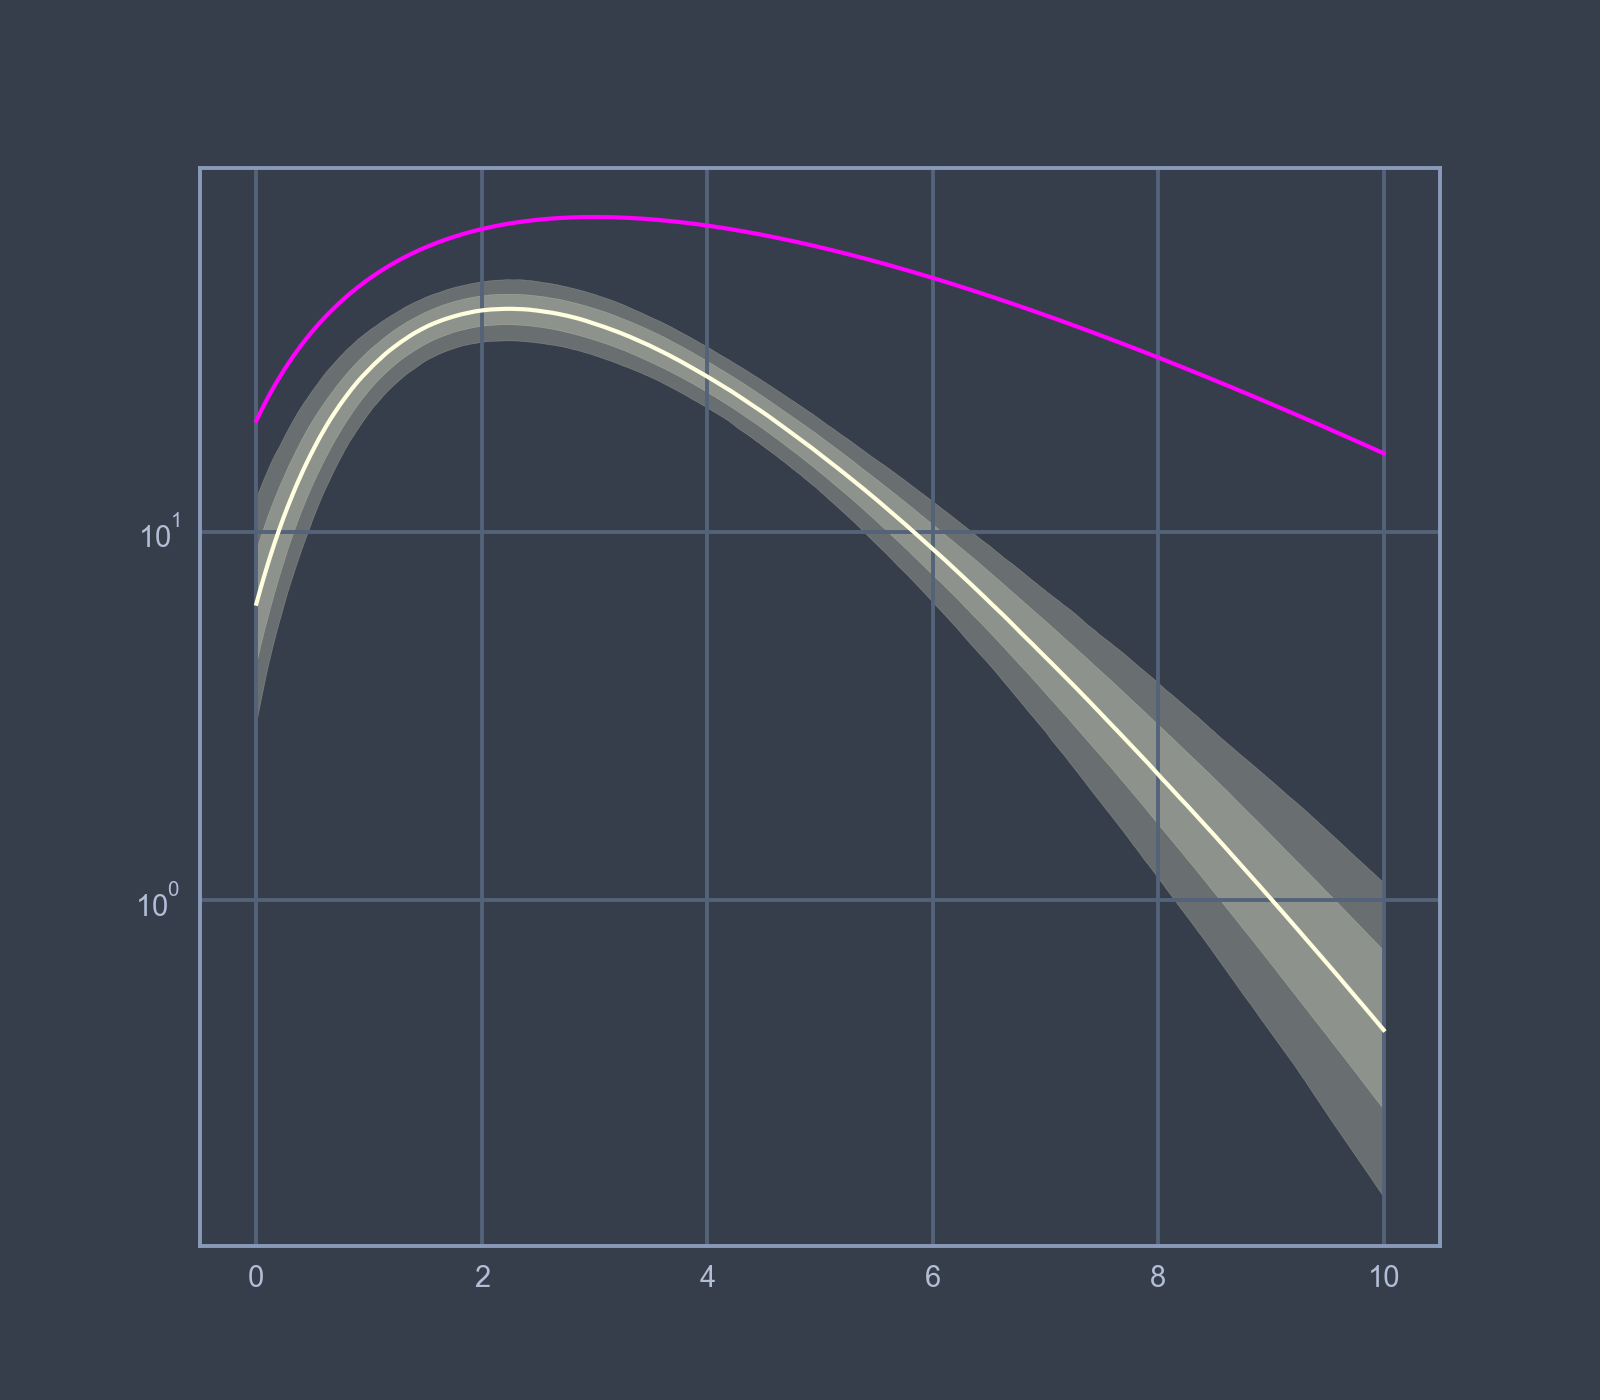

In [39]:
fig, ax = plt.subplots()

ax.semilogy(zmodel, np.median(chain_selected['dNdz_model'], axis=0),color='lightyellow')
ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 84, axis=0), np.percentile(chain_selected['dNdz_model'], 16, axis=0), color='lightyellow', alpha=0.25)
ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 97.5, axis=0), np.percentile(chain_selected['dNdz_model'], 2.5, axis=0), color='lightyellow', alpha=0.25)
ax.semilogy(zmodel, dNdz(zmodel, 20., 2., 2.), '-', color='magenta')


#ax.semilogy(zmodel, dNdz(zmodel, 5., 4., .8), '-', color='blue')
#ax.semilogy(zmodel, dNdz(zmodel, 200., 2.), '-', color='blue')